In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [8]:
df = pd.read_csv("sample_data/HIST_PAINEL_COVIDBR_2021_Parte2_20fev2022.csv", sep=';')
df.head(5)

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-07-01,26,210147125.0,18622304,65163,520095,2029,16858632.0,1180443.0,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-07-02,26,210147125.0,18687469,65165,521952,1857,16931272.0,1170937.0,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-07-03,26,210147125.0,18742025,54556,523587,1635,16989351.0,1176166.0,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-07-04,27,210147125.0,18769808,27783,524417,830,17033808.0,1184630.0,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-07-05,27,210147125.0,18792511,22703,525112,695,17082876.0,1162515.0,NaN


In [9]:
# Filtrando por estado e municipios não nulos
df_sp = df.loc[df.municipio == "São José dos Campos"]
# df_sp = df.loc[df.municipio.notna()]
df_sp.head(5)

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
711712,Sudeste,SP,São José dos Campos,35,354990.0,35171.0,ALTO VALE DO PARAIBA,2021-07-01,26,721944.0,82374,331,1732,6,NaN,NaN,0.0
711713,Sudeste,SP,São José dos Campos,35,354990.0,35171.0,ALTO VALE DO PARAIBA,2021-07-02,26,721944.0,82633,259,1737,5,NaN,NaN,0.0
711714,Sudeste,SP,São José dos Campos,35,354990.0,35171.0,ALTO VALE DO PARAIBA,2021-07-03,26,721944.0,82842,209,1741,4,NaN,NaN,0.0
711715,Sudeste,SP,São José dos Campos,35,354990.0,35171.0,ALTO VALE DO PARAIBA,2021-07-04,27,721944.0,82984,142,1747,6,NaN,NaN,0.0
711716,Sudeste,SP,São José dos Campos,35,354990.0,35171.0,ALTO VALE DO PARAIBA,2021-07-05,27,721944.0,83105,121,1747,0,NaN,NaN,0.0


In [10]:
df_sp.count()

regiao                    184
estado                    184
municipio                 184
coduf                     184
codmun                    184
codRegiaoSaude            184
nomeRegiaoSaude           184
data                      184
semanaEpi                 184
populacaoTCU2019          184
casosAcumulado            184
casosNovos                184
obitosAcumulado           184
obitosNovos               184
Recuperadosnovos            0
emAcompanhamentoNovos       0
interior/metropolitana    184
dtype: int64

In [11]:
df_sp = df_sp.set_index('data')
df_sp.index = pd.to_datetime(df_sp.index, format='%Y-%m-%d')
df_sp = df_sp[['municipio','casosAcumulado']].groupby('data').sum()
df_sp.head(5)

,casosAcumulado
data,
2021-07-01,82374
2021-07-02,82633
2021-07-03,82842
2021-07-04,82984
2021-07-05,83105


In [12]:
# Buscando a data mais antiga e a mais atual
df_sp.iloc[[0, -1]]

,casosAcumulado
data,
2021-07-01,82374
2021-12-31,94285


In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


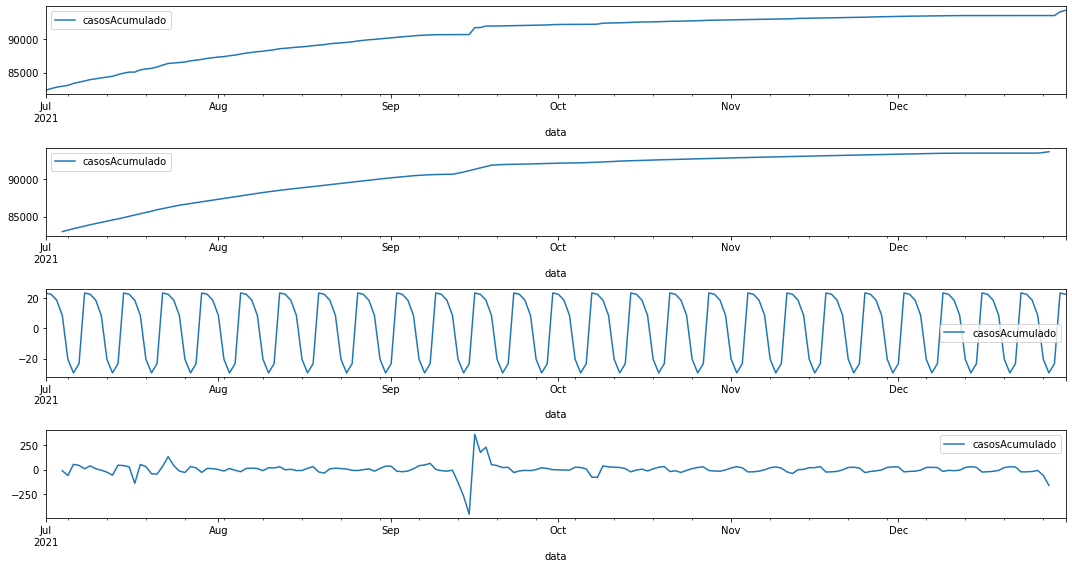

In [14]:
seasonplot = seasonal_decompose(df_sp)
# plotar a decomposicao
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1)
seasonplot.trend.plot(ax=ax2)
seasonplot.seasonal.plot(ax=ax3)
seasonplot.resid.plot(ax=ax4)
plt.tight_layout()

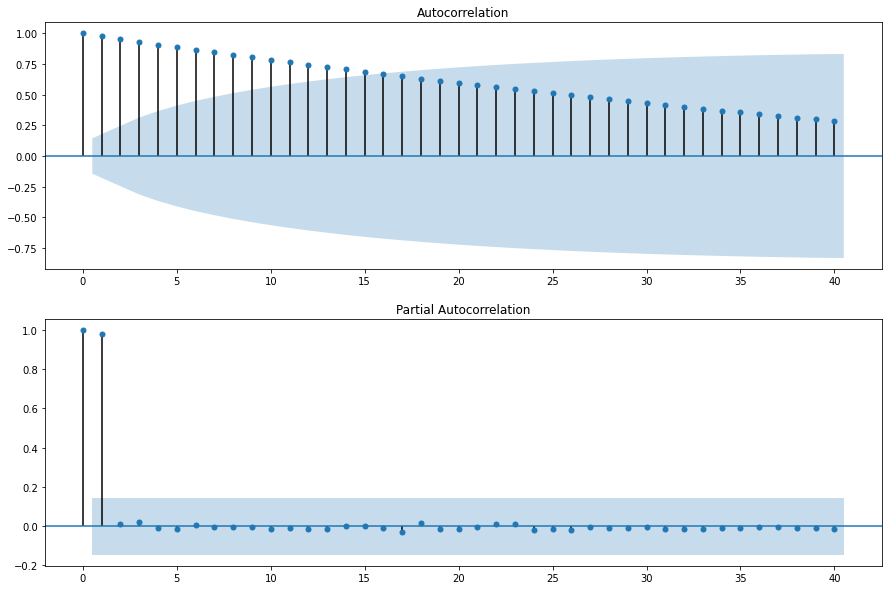

In [15]:
import statsmodels.api as sm
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
sm.graphics.tsa.plot_acf(df_sp.values.squeeze(), lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df_sp.values.squeeze(), lags=40, ax=ax2)
plt.show()

In [16]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 41.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [17]:
from pmdarima.arima import auto_arima
bruteforce_modelo = auto_arima(df_sp, start_p=0, start_d=0 , 
                               start_q=0,max_p=8, max_d=8,max_q=8, m=7, start_P=0, 
                               seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                               suppress_warnings=True, stepwise=False)

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2211.899, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=2168.333, Time=0.46 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=2170.273, Time=1.55 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=2182.586, Time=0.22 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=2170.283, Time=0.58 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=4.17 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=2171.679, Time=0.73 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=2171.605, Time=1.40 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=inf, Time=4.52 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=2213.778, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=2169.802, Time=0.99 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=2171.704, Time=1.91 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=2184.378, Time=0.48 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=2171.719, Time=0.85 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=4.45 sec
 ARIMA(0,1,1)(2,1,0)[7]  

In [18]:
print(f"Resultado AIC: {bruteforce_modelo.aic()}")
print(f"Resultado melhores parametros (p,d,q): {bruteforce_modelo.order}")

Resultado AIC: 2159.7089106142785
Resultado melhores parametros (p,d,q): (1, 1, 1)


In [19]:
futuro_forecast = bruteforce_modelo.predict(n_periods=30)

In [20]:
import datetime 
# PEGAR DIA 01-01-2022 COMO DATA ATUAL
dataatual = datetime.datetime.today()
dataatual = datetime.datetime.today() - datetime.timedelta(days=51)
lista_datas = [dataatual + datetime.timedelta(days=x) for x in range(30)]
lista_datas = [pd.datetime.strftime(i,'%Y-%m-%d') for i in lista_datas]
lista_datas


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


['2022-01-02',
 '2022-01-03',
 '2022-01-04',
 '2022-01-05',
 '2022-01-06',
 '2022-01-07',
 '2022-01-08',
 '2022-01-09',
 '2022-01-10',
 '2022-01-11',
 '2022-01-12',
 '2022-01-13',
 '2022-01-14',
 '2022-01-15',
 '2022-01-16',
 '2022-01-17',
 '2022-01-18',
 '2022-01-19',
 '2022-01-20',
 '2022-01-21',
 '2022-01-22',
 '2022-01-23',
 '2022-01-24',
 '2022-01-25',
 '2022-01-26',
 '2022-01-27',
 '2022-01-28',
 '2022-01-29',
 '2022-01-30',
 '2022-01-31']

In [21]:
futuro_forecast = bruteforce_modelo.predict(n_periods=30)
futuro_forecast = pd.DataFrame(futuro_forecast,index = lista_datas,columns=["casosAcumulado"])
futuro_forecast.index.name = 'data'
futuro_forecast.index = pd.to_datetime(futuro_forecast.index)
futuro_forecast.casosAcumulado = round(futuro_forecast.casosAcumulado,0)
futuro_forecast.head(2)

,casosAcumulado
data,
2022-01-02,94348.0
2022-01-03,94401.0


In [22]:
final = pd.concat([df_sp,futuro_forecast])
final.head(2)

,casosAcumulado
data,
2021-07-01,82374.0
2021-07-02,82633.0


In [24]:
import plotly.graph_objects as go   
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_sp.index, y=df_sp.casosAcumulado,mode='lines+markers',
                    name='Atual'))

fig.add_trace(go.Scatter(x=futuro_forecast.index, y=futuro_forecast.casosAcumulado,mode='lines+markers', name='Previsto',
line=dict(dash='dashdot')))

fig.update_layout(title="Previsão para os proximos 30 dias, casos acumulados COVID-19 SJC", width=800, height=400)
fig.show()

In [25]:
# PEGAR 15 DIAS ANTES DO DIA 01-01-2022
dataatual = datetime.datetime.today()
dataatual = datetime.datetime.today() - datetime.timedelta(days=66)
lista_datas = [dataatual + datetime.timedelta(days=x) for x in range(15)]
lista_datas = [pd.datetime.strftime(i,'%Y-%m-%d') for i in lista_datas]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [26]:
lista_datas

['2021-12-18',
 '2021-12-19',
 '2021-12-20',
 '2021-12-21',
 '2021-12-22',
 '2021-12-23',
 '2021-12-24',
 '2021-12-25',
 '2021-12-26',
 '2021-12-27',
 '2021-12-28',
 '2021-12-29',
 '2021-12-30',
 '2021-12-31',
 '2022-01-01']

In [28]:
df_validacao = df_sp.iloc[0:-29]

In [29]:
df_validacao.iloc[[0,-1]]

,casosAcumulado
data,
2021-07-01,82374
2021-12-02,93403


In [35]:
from pmdarima.arima import auto_arima
valid_model = auto_arima(df_validacao, start_p=0, start_d=0 ,start_q=0,max_p=8, 
                         max_d=8,max_q=8, m=7, start_P=0, seasonal=True, trace=True,
                         error_action='ignore',suppress_warnings=True, stepwise=False)

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1933.134, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1884.396, Time=0.38 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1882.962, Time=0.86 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1879.625, Time=0.67 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=1881.619, Time=0.96 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=1883.264, Time=1.22 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1897.842, Time=0.12 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1881.870, Time=0.50 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1882.303, Time=0.97 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1881.621, Time=1.00 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1896.766, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1880.670, Time=0.24 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1884.235, Time=0.60 sec
 ARIMA(3,2,0)(0,0,0)

In [36]:
print(f"Resultado AIC: {valid_model.aic()}")
print(f"Resultado melhores parametros (p,d,q): {valid_model.order}")

Resultado AIC: 1879.6250963248065
Resultado melhores parametros (p,d,q): (0, 2, 3)


In [37]:
valid_forecast = valid_model.predict(n_periods=15)
valid_forecast = pd.DataFrame(valid_forecast,index = lista_datas,columns=["casosAcumulado"])
valid_forecast.index.name = 'data'
valid_forecast.index = pd.to_datetime(valid_forecast.index)
valid_forecast.casosAcumulado = round(valid_forecast.casosAcumulado,0)
valid_forecast.head(2)

,casosAcumulado
data,
2021-12-18,93400.0
2021-12-19,93392.0


In [34]:
import plotly.graph_objects as go   
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_sp.index, y=df_sp.casosAcumulado,mode='lines+markers',
                    name='Atual'))

fig.add_trace(go.Scatter(x=valid_forecast.index, y=valid_forecast.casosAcumulado,mode='lines+markers', name='Validação 15 dias',
line=dict(dash='dashdot')))

fig.add_trace(go.Scatter(x=futuro_forecast.index, y=futuro_forecast.casosAcumulado,mode='lines+markers', name='Previsto 30 dias',
line=dict(dash='dashdot')))

fig.update_layout(title="Validando eficiência do modelo com dados ja existentes.", width=800, height=400)
fig.show()